# CS 7180 Geometric Deep Learning, Homework 4: Steerable CNNs

## TLDR

* **To start solving the homework, create a copy of this notebook:** `File -> Save a copy in Drive`.
* **To hand-in the homework**, submit a PDF with your answers on `gradescope.com` and add `biza.o@northeastern.edu` as a `Commentor` using the `Share` button **in your copy of this notebook**.
* Deadline is Sunday March 5th, 11 PM EST.

## Solving the homework in Google Colab

[Google Colab](colab.research.google) is an online platform for running interactive Python session with [Jupyter](https://jupyter.org/) / [IPython](https://ipython.org/) (`.ipynb`) notebooks. We recommend you use it so that we can avoid problems with setting up local Python environment and so that we can use free GPUs to accelerate neural network training. 

If you have not used Python notebooks before, please check [this overview](https://colab.research.google.com/notebooks/basic_features_overview.ipynb). If you are new to Python, you can refer to [this excellent Python Numpy Tutorial](https://cs231n.github.io/python-numpy-tutorial/). We will be using [Numpy](https://numpy.org/) and [PyTorch](https://pytorch.org/) extensively to prepare data and train neural networks. For a PyTorch tutorial, follow [this link](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html) and select `Run in Google Colab`.

You cannot save the changes you made to this notebook. To start solving the homework, create a copy that you can edit: `File -> Save a copy in Drive`.

By default, your instance will run on a CPU. That is ok, but training neural network might take a while. You can (and should) request a free GPU instance using: `Runtime` -> `Change runtime type` -> `Hardware accelerator` -> `GPU` (-> `Delete previous runtime` -> `OK`). Note that your GPU instance will stop due to inactivity or a 12-hour time limit, but you can usually immediately request a new one. This will however delete all your progress (e.g. network weights) that is not saved in your code blocks, text blocks or Google Drive.

Another useful command to reset your instance (keeps your GPU):
`Runtime` -> `Restart runtime`.

## (Optional) Solving the homework on your local machine
You can download this notebook using `Download -> Download .ipynb` and run it on your local machine. To set up a local environment, download [Python 3.6](https://www.python.org/) or later, set up a [virtual environment](https://docs.python.org/3/library/venv.html) and install [relevant packages](https://pip.pypa.io/en/stable/reference/requirements-file-format/) using [pip](https://pypi.org/project/pip/). On Linux, you would do something like this:

```
# Assuming you have Python >= 3.6 and python3-venv installed.
python3 -m venv venv
source ./venv/bin/activate
# Prevents opencv-python (which we might use) from taking forever to install.
pip install --upgrade pip setuptools wheel
pip install -r requirements.txt
pip install jupyter
# Run in the directory where this notebook is located. A browser window should open.
jupyter notebook .
```

You can run `!pip freeze` *in colab* to see the version of packages we are using. Then, you can copy the relevant packages (i.e. the ones we import) to your `requirements.txt` file or install them using `pip install x` in command line or `!pip install x` directly in the notebook. Importantly, to run on your GPU, you will need to install a `torch` version that matches your [CUDA](https://developer.nvidia.com/cuda-downloads) and [cuDNN](https://developer.nvidia.com/cudnn) versions. Please refer to the [PyTorch website](https://pytorch.org/). We might use the CPU version of tensorflow to prepare datasets.

# Python setup

In [ ]:
# A library for steerable CNNs.
!pip install e2cnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
# I like to use typing, but you don't have to!
from typing import Any, Dict, Tuple, Union

import networkx as nx
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import shift
import scipy.sparse as sp
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import datasets, transforms
from e2cnn import gspaces
from e2cnn import nn as e2cnn_nn

# We might use tensorflow to load datasets.
# Prevent tensorflow from stealing our GPU.
tf.config.experimental.set_visible_devices([], "GPU")

# Interactive plots.
%matplotlib inline

In [ ]:
# Runtime -> Change runtime type -> Hardware accelerator -> GPU (-> Delete previous runtime -> OK).
if torch.cuda.is_available() and torch.cuda.device_count() > 0:
  print("PyTorch running on a GPU. Use '.to(device)' to move tensors and models to GPU.")
  device = torch.device("cuda:0")
else:
  print("WARNING: PyTorch running on a CPU. See comment above to request a GPU instance.")
  device = torch.device("cpu")

PyTorch running on a GPU. Use '.to(device)' to move tensors and models to GPU.


# Part 1: Training a convolutional network equivariant to discrete rotations. Testing on rotated MNIST.

We will continue with the MNIST dataset from Homework 1. Our goal is to design neural networks that can make good predictions about rotated versions of the MNIST characters when trained only on the original images. For this purpose, we will use original MNIST for training and rotated MNIST for validation.

## Data preprocessing

In [ ]:
# Download rotated MNIST.
!wget -nc http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
!unzip -n mnist_rotation_new.zip -d mnist_rotation_new

File ‘mnist_rotation_new.zip’ already there; not retrieving.

Archive:  mnist_rotation_new.zip


In [ ]:
class MnistRotDataset(torch.utils.data.Dataset):
    
    def __init__(self, mode: str, transform=None):
        assert mode in ["train", "test"]
            
        if mode == "train":
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat"
        else:
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat"
        
        self.transform = transform

        data = np.loadtxt(file, delimiter=" ")
            
        self.images = data[:, :-1].reshape(-1, 28, 28).astype(np.float32)
        self.labels = data[:, -1].astype(np.int64)
        self.num_samples = len(self.labels)
    
    def __getitem__(self, index: int):
        image, label = self.images[index], self.labels[index]
        image = Image.fromarray(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self) -> int:
        return len(self.labels)

In [ ]:
def prepare_mnist(batch_size: int) -> Tuple[DataLoader, DataLoader]:
  """Prepare MNIST training and evaluation data loaders in PyTorch.
  https://github.com/pytorch/examples/blob/main/mnist/main.py
  """
  t = transforms.ToTensor()

  train_ds = datasets.MNIST("/tmp/mnist", download=True, train=True, transform=t)
  eval_ds = datasets.MNIST("/tmp/mnist", download=True, train=False, transform=t)

  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
  eval_loader = DataLoader(eval_ds, batch_size=batch_size, shuffle=False, num_workers=1)

  return train_loader, eval_loader

In [ ]:
def prepare_rotated_mnist(batch_size: int) -> Tuple[DataLoader, DataLoader]:
  """Prepare rotated MNIST training and evaluation data loaders in PyTorch.
  https://github.com/QUVA-Lab/e2cnn/blob/master/examples/model.ipynb
  """
  t = transforms.ToTensor()

  train_ds = MnistRotDataset("train", transform=t)
  eval_ds = MnistRotDataset("test", transform=t)

  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
  eval_loader = DataLoader(eval_ds, batch_size=batch_size, shuffle=False, num_workers=1)

  return train_loader, eval_loader

### Original MNIST (train_loader, eval_loader)

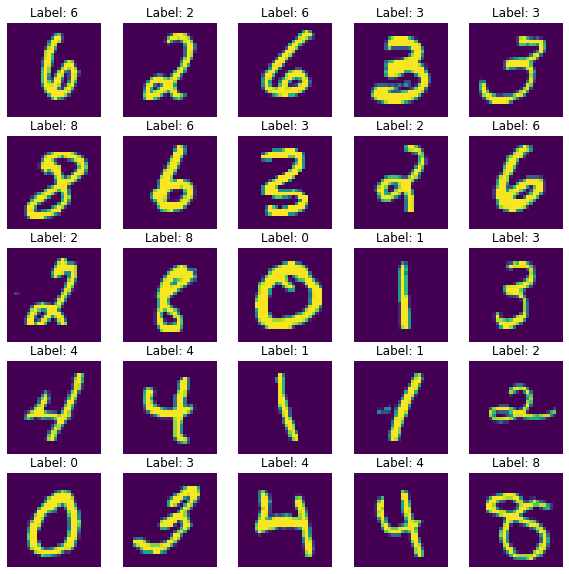

In [ ]:
train_loader, eval_loader = prepare_mnist(128)
example = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(5*5):
  plt.subplot(5, 5, 1 + i)
  plt.title("Label: {:d}".format(example[1][i]))
  plt.imshow(example[0][i][0])
  plt.axis("off")

### Rotated MNIST (train_rot_loader, eval_rot_loader)

Note that this dataset contains continuous rotations and reflections of the original images.

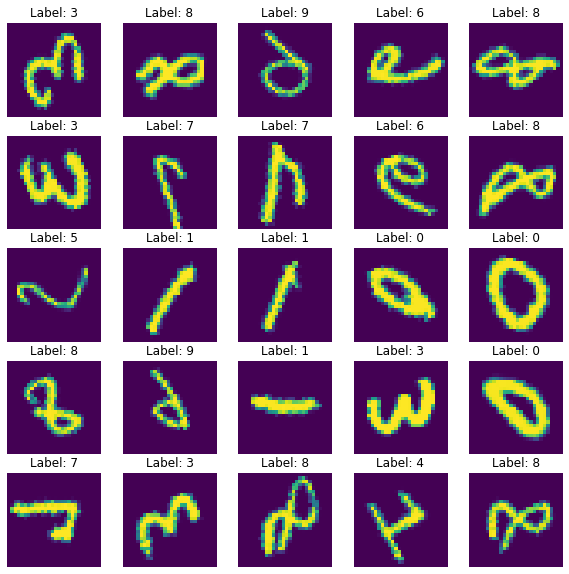

In [ ]:
train_rot_loader, eval_rot_loader = prepare_rotated_mnist(128)
example = next(iter(train_rot_loader))
plt.figure(figsize=(10, 10))
for i in range(5*5):
  plt.subplot(5, 5, 1 + i)
  plt.title("Label: {:d}".format(example[1][i]))
  plt.imshow(example[0][i][0])
  plt.axis("off")

## Training a baseline

In [ ]:
class CNNBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(5,5), stride=(2,2), padding=(2,2))
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(5,5), stride=(2,2), padding=(2,2))
        self.conv3 = nn.Conv2d(64, 64, kernel_size=(5,5), stride=(2,2),padding=(2,2))
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(5,5), stride=(2,2),padding=(2,2))
        self.linear1 = nn.Linear(256, 128)
        self.linear2 = nn.Linear(128, 10)
        self.act = nn.ReLU()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.act(self.conv3(x))
        x = self.act(self.conv4(x))

        x = x.reshape(x.shape[0], -1)
        x = self.act(self.linear1(x))
        x = F.log_softmax(self.linear2(x), dim=-1)

        return x

In [ ]:
def train(train_loader: DataLoader, model: nn.Module,
          optimizer: optim.Optimizer, epochs: int):

  losses = []
  # 1 epoch = 1 pass through the dataset.
  for epoch in range(epochs):
    print("Epoch {:d} / {:d}".format(epoch, epochs))
    # train_loader steps once it iterates over all data.
    for train_step, batch in enumerate(train_loader):
      # train_loader gives us batched images (CxHxW) and labels (integers).
      # If we are using a GPU we need to move them to the device.
      inputs, labels = batch[0].to(device), batch[1].to(device)
      # Reset last optimization step.
      optimizer.zero_grad()
      # Make prediction, calculate loss.
      outputs = model(inputs)
      loss = F.nll_loss(outputs, labels)
      # Compute gradients and update weights.
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

      if train_step > 0 and train_step % 50 == 0:
        print("Mean of last 50 losses: {:f}".format(np.mean(losses[-50:])))

  plt.plot(losses)
  plt.xlabel("Training step")
  plt.ylabel("Loss")

In [ ]:
# We don't need gradients during evaluation.
@torch.no_grad()
def evaluate(eval_loader: DataLoader, model: nn.Module):

  accuracy = []

  for batch in eval_loader:
    inputs, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(inputs)
    pred_labels = torch.argmax(outputs, dim=-1)
    tmp = (labels == pred_labels).float().mean()
    accuracy.append(tmp.item())

  # We compute the mean of means over batches.
  # This could be slightly skewed if the last batch is smaller.
  # Does not matter too much here.
  accuracy = np.mean(accuracy)
  print("Correct answer in {:.1f}% of cases.".format(accuracy * 100))

In [ ]:
@torch.no_grad()
def plot_predictions(eval_loader: DataLoader, model: nn.Module):
  example = next(iter(eval_loader))
  inputs = example[0].to(device)
  outputs = model(inputs)
  pred_labels = torch.argmax(outputs, dim=-1).to("cpu").numpy()

  plt.figure(figsize=(10, 10))
  for i in range(5*5):
    plt.subplot(5, 5, 1 + i)
    plt.title("Label: {:d}".format(pred_labels[i]))
    plt.imshow(example[0][i][0])
    plt.axis("off")

Epoch 0 / 5
Mean of last 50 losses: 1.065229
Mean of last 50 losses: 0.286794
Mean of last 50 losses: 0.237128
Mean of last 50 losses: 0.154430
Mean of last 50 losses: 0.148282
Mean of last 50 losses: 0.119674
Mean of last 50 losses: 0.117081
Mean of last 50 losses: 0.102671
Mean of last 50 losses: 0.092539
Epoch 1 / 5
Mean of last 50 losses: 0.072521
Mean of last 50 losses: 0.077215
Mean of last 50 losses: 0.067480
Mean of last 50 losses: 0.078019
Mean of last 50 losses: 0.065316
Mean of last 50 losses: 0.058945
Mean of last 50 losses: 0.056604
Mean of last 50 losses: 0.056360
Mean of last 50 losses: 0.056196
Epoch 2 / 5
Mean of last 50 losses: 0.034487
Mean of last 50 losses: 0.040889
Mean of last 50 losses: 0.048287
Mean of last 50 losses: 0.049204
Mean of last 50 losses: 0.050001
Mean of last 50 losses: 0.040576
Mean of last 50 losses: 0.043424
Mean of last 50 losses: 0.041786
Mean of last 50 losses: 0.046294
Epoch 3 / 5
Mean of last 50 losses: 0.029657
Mean of last 50 losses: 0.02

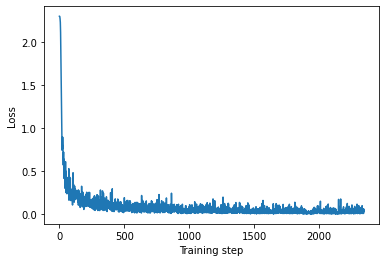

In [ ]:
model = CNNBaseline().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(train_loader, model, optimizer, 5)

### Evaluating on the original MNIST dataset

In [ ]:
evaluate(eval_loader, model)

Correct answer in 98.8% of cases.


### Evaluating on the rotated MNIST dataset (you should use this one)

In [ ]:
evaluate(eval_rot_loader, model)

Correct answer in 26.6% of cases.


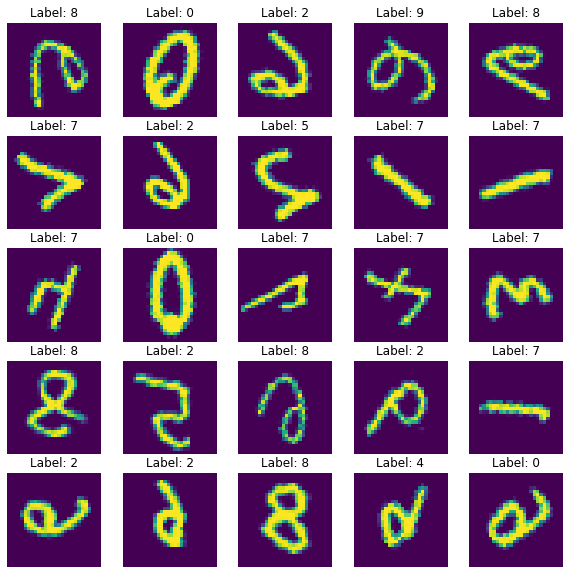

In [ ]:
plot_predictions(eval_rot_loader, model)

## == Task 1 ==

[**Question 1**] Implement an C4-invariant (cyclic group -- discrete rotations) convolutional network using the [e2cnn library](https://github.com/QUVA-Lab/e2cnn). You can follow [this tutorial](https://github.com/QUVA-Lab/e2cnn/blob/master/examples/introduction.ipynb). Compare baseline and C4-invarant convolutional networks when trained on MNIST and tested on rotated MNIST. Report learning curves (training step vs training loss) and validation accuracies. Why cannot the baseline CNN classify rotated images well? Does C4-invariance help?

[**Question 2**] Ensure that your C4-invariant convolutional network is invariant to 90 degree rotations of the input image. Describe how you tested the invariance.

[**Question 3**] Implement D1, D2, D4, D8, C2 and C8 invariant convolutional networks and compare their validation accuracies on rotated MNIST to your C4-invariant convolutional network. Dn is the dihedral group (reflections and discrete rotations) and Cn is the cyclic group (discrete rotations). D1 represents reflections only. *I recommend (but it is up to you) that you create a single class and pass arguments for the group order (N) and a boolean argument for including reflections in addition to rotations. The rest should be a simple change to your e2cnn code.*

# (Optional!) Part 2: Implementing an SO(2) invariant CNN.

The e2cnn library can implement SO(2)-invariant convolutional networks (approximately invariant to any continuous rotation of the image). We usually approximate equivariance / invariance to continuous rotations using [circular (2D) or spherical (3D) harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics). This approximation, which uses the Fourier basis, however introduces additional complexity in building the model and additional hyper-parameters to tune.

You can start by taking a look at [Table 3 in this paper](https://arxiv.org/abs/1911.08251) and [their associated repository](https://github.com/QUVA-Lab/e2cnn_experiments). In particular, [this bash script](https://github.com/QUVA-Lab/e2cnn_experiments/blob/master/experiments/mnist_bench.sh) has the arguments for [this python file](https://github.com/QUVA-Lab/e2cnn_experiments/blob/master/experiments/models/exp_e2sfcnn.py), which implements several different SO(2)-invariant convolutional networks.